## 뉴욕 택시 데이터 EDA

### 라이브러리 설치

In [1]:
import chart_studio.plotly as py
import cufflinks as cf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

cf.go_offline()

### 1월 전체 택시 운행 수

In [2]:
query = """
SELECT 
    DATETIME_TRUNC(pickup_datetime, hour) as pickup_hour,
    count(*) as cnt
FROM `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2015` 
WHERE EXTRACT(MONTH from pickup_datetime) = 1
GROUP BY pickup_hour
ORDER BY pickup_hour
"""

df = pd.read_gbq(query= query, dialect='standard', project_id='new-york-taxi-309501', auth_local_webserver=True)

Downloading: 100%|████████████████████████████████████████████████████████████████| 744/744 [00:01<00:00, 683.54rows/s]


* 구글 빅쿼리( Google BigGuery )에서 SQL언어를 사용해 데이터를 추출
* 문법은 'Standard'을 사용
* 추출한 데이터를 판다스 데이터프레임으로 만들어주는 함수 ( read_gbq () ) 사용

In [3]:
df.head(10)

,pickup_hour,cnt
0,2015-01-01 00:00:00,28312
1,2015-01-01 01:00:00,31707
2,2015-01-01 02:00:00,28068
3,2015-01-01 03:00:00,24288
4,2015-01-01 04:00:00,17081
5,2015-01-01 05:00:00,9112
6,2015-01-01 06:00:00,6637
7,2015-01-01 07:00:00,6011
8,2015-01-01 08:00:00,5586
9,2015-01-01 09:00:00,6977


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 2 columns):
pickup_hour    744 non-null datetime64[ns]
cnt            744 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.8 KB


In [5]:
df = df.set_index('pickup_hour')
df.head(10)

,cnt
pickup_hour,
2015-01-01 00:00:00,28312
2015-01-01 01:00:00,31707
2015-01-01 02:00:00,28068
2015-01-01 03:00:00,24288
2015-01-01 04:00:00,17081
2015-01-01 05:00:00,9112
2015-01-01 06:00:00,6637
2015-01-01 07:00:00,6011
2015-01-01 08:00:00,5586


In [6]:
df.iplot(kind='scatter', xTitle='날짜',yTitle='수요',title='2015년 1월 뉴욕 택시 수요')

* Jan 27에 급격히 건수가 하락
* 미국에서 2015년 1월 23일에 27인치 만큼의 큰 눈폭풍이 발생해서 전체 택시 운행 횟수가 크게 감소  
--> 도메인의 중요성을 깨달았습니다

### 일자별 택시 운행 수

In [7]:
df['date'] = df.index.date
df.groupby(['date'])['cnt'].sum().iplot()

### 시간대, 요일별 택시 운행 수

In [8]:
df.head()

,cnt,date
pickup_hour,,
2015-01-01 00:00:00,28312,2015-01-01
2015-01-01 01:00:00,31707,2015-01-01
2015-01-01 02:00:00,28068,2015-01-01
2015-01-01 03:00:00,24288,2015-01-01
2015-01-01 04:00:00,17081,2015-01-01


In [9]:
df['week'] = df.index.week
df['weekday'] = df.index.weekday
df['hour'] = df.index.hour

In [10]:
df.head()

,cnt,date,week,weekday,hour
pickup_hour,,,,,
2015-01-01 00:00:00,28312,2015-01-01,1,3,0
2015-01-01 01:00:00,31707,2015-01-01,1,3,1
2015-01-01 02:00:00,28068,2015-01-01,1,3,2
2015-01-01 03:00:00,24288,2015-01-01,1,3,3
2015-01-01 04:00:00,17081,2015-01-01,1,3,4


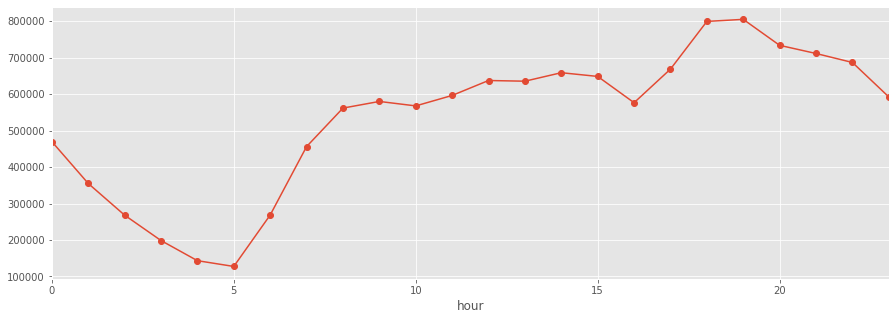

In [11]:
df.groupby(['hour'])['cnt'].sum().plot(figsize=(15,5),kind='line',style='-o')

* 피크타임 : 18 ~ 19시  
* 오프피크타임 : 05시

In [12]:
df.groupby(['hour','weekday'])['cnt'].mean().unstack().iplot(xTitle='시간', yTitle='수요량')

In [13]:
df.groupby(['weekday'])['cnt'].sum().iplot(kind='bar',xTitle='요일',yTitle='수요량')

### 평일/ 주말별 택시 운행 수

In [14]:
pd.DatetimeIndex(df.index)

DatetimeIndex(['2015-01-01 00:00:00', '2015-01-01 01:00:00',
               '2015-01-01 02:00:00', '2015-01-01 03:00:00',
               '2015-01-01 04:00:00', '2015-01-01 05:00:00',
               '2015-01-01 06:00:00', '2015-01-01 07:00:00',
               '2015-01-01 08:00:00', '2015-01-01 09:00:00',
               ...
               '2015-01-31 14:00:00', '2015-01-31 15:00:00',
               '2015-01-31 16:00:00', '2015-01-31 17:00:00',
               '2015-01-31 18:00:00', '2015-01-31 19:00:00',
               '2015-01-31 20:00:00', '2015-01-31 21:00:00',
               '2015-01-31 22:00:00', '2015-01-31 23:00:00'],
              dtype='datetime64[ns]', name='pickup_hour', length=744, freq=None)

In [15]:
df['weekend']=(df.index.dayofweek // 5 == 1).astype(int)

In [16]:
df.groupby(['hour','weekend'])['cnt'].mean().unstack().iplot(title="평일과 주말 이용량 차이", xTitle='시간',yTitle='수요량')

* 0 ~ 5시 사이에는 주말( 1 )의 이용량이 평일과 비교시 많은 것으로 나타납니다.  
: ex) 주말에는 밤 늦게까지 약속이 있는 경우  
  
* 5 ~10시 사이에는 평일( 0 )의 이용량이 주말과 비교시 많은 것으로 나타납니다.  
: ex) 오전 출근시간

### 요일별 시간대별 히트맵

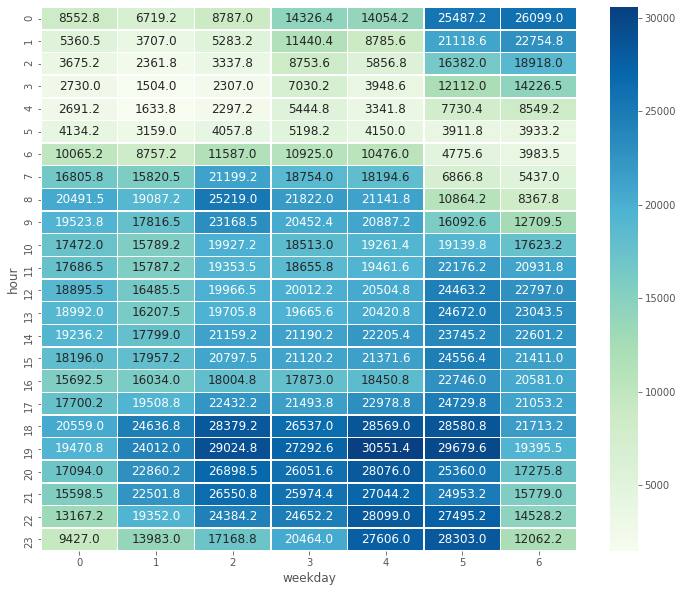

In [17]:
plt.figure(figsize=(12,10))
sns.heatmap(df.groupby(['hour','weekday'])['cnt'].mean().unstack(),
            lw=0.5,annot=True,cmap='GnBu',fmt='.1f', annot_kws={'size':12})

* 평일에는 18 ~ 19시에 택시 운행 수가 증가
* 주말에는 금요일 오후부터 택시 운행 수 증가, 0 ~ 4시까지 운행 수는 평일과 비교 시 상당히 증가 